### - PCA and Clustering  for Cell painting Level-4 profiles (per dose treament)

#### - Use Silhouette and Davies Bouldin scores to assess the number of clusters from K-Means
#### - Use BIC scores to assess the number of clusters from Gaussian Mixture Models (GMM)

[reference](https://sites.northwestern.edu/msia/2016/12/08/k-means-shouldnt-be-our-only-choice/)
[refeerences](https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/)

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc

from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture as GMM
import os
import pathlib
import pandas as pd
import numpy as np
import re
from os import walk
from collections import Counter
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pycytominer.cyto_utils import infer_cp_features
sns.set_style("darkgrid")
##sns.set_palette(["red", "green", "orange","blue","gray","purple"])
sns.set_context("talk")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
number_of_pcs = 300

In [3]:
cp_level4_path = '../1.Data-exploration/Profiles_level4/cell_painting/cellpainting_lvl4_cpd_replicate_datasets'
output_path = "results/cell_painting"

In [4]:
# Load common compounds
common_file = pathlib.Path(
    "..", "6.paper_figures", "data", "significant_compounds_by_threshold_both_assays.tsv.gz"
)
common_df = pd.read_csv(common_file, sep="\t")

common_compounds = common_df.compound.unique()
print(len(common_compounds))
print(common_df.shape)
common_df.head(2)

1327
(7962, 10)


,compound,dose,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
0,17-hydroxyprogesterone-caproate,0.04 uM,0.060655,0.024738,True,False,False,5,3,8
1,2-iminobiotin,0.04 uM,0.042700,-0.133693,False,False,False,0,2,2


In [5]:
df_level4 = pd.read_csv(os.path.join(cp_level4_path, 'cp_level4_cpd_replicates.csv.gz'), 
                        compression='gzip',low_memory = False)

df_level4.pert_iname = df_level4.pert_iname.str.lower()

df_level4 = df_level4.query("pert_iname in @common_compounds").reset_index(drop=True)

print(df_level4.pert_iname.nunique())
print(df_level4.shape)
df_level4.head(2)

1327
(40253, 812)


,Metadata_broad_sample,Metadata_pert_id,Metadata_Plate,Metadata_Well,Metadata_broad_id,Metadata_moa,Metadata_dose_recode,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,...,Nuclei_Texture_SumVariance_Mito_5_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,broad_id,pert_iname,moa,replicate_name
0,BRD-A92630576-050-24-1,BRD-A92630576,SQ00015211,A13,BRD-A92630576,opioid receptor agonist,6,0.551978,0.383727,0.140345,...,-0.512858,-2.860081,-1.306321,1.790279,-3.701515,-4.792265,BRD-A92630576,trimebutine,Opioid receptor agonist,replicate_3294
1,BRD-A92630576-050-24-1,BRD-A92630576,SQ00015211,A14,BRD-A92630576,opioid receptor agonist,5,-0.194387,0.322902,-0.849332,...,-0.592264,-0.653474,0.165553,-0.481435,-1.517210,-0.603459,BRD-A92630576,trimebutine,Opioid receptor agonist,replicate_3295


In [6]:
def save_to_csv(df, path, file_name, compress=None):
    """saves dataframes to csv"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    df.to_csv(os.path.join(path, file_name), index=False, compression=compress)

In [7]:
def extract_dose_df(df, dose_num):
    """Extract data for each treatment dose"""
    df_dose = df[df['Metadata_dose_recode'] == dose_num].reset_index(drop=True)
    metadata_cols = ['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_Plate', 
                     'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 'Metadata_dose_recode', 
                     'broad_id', 'moa', 'replicate_name', 'pert_iname']
    df_dose.drop(metadata_cols, axis = 1, inplace = True)
    return df_dose

In [8]:
def transform_pca(df, dose_num, no_of_pcs =150):
    """Perform PCA Analysis"""
    scaler = StandardScaler()
    scaled_agg = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(data = scaled_agg, columns = ['feat_' + str(x) for x in range(1,df.shape[1]+1)])
    #lets extract features with the most variance in our dataset
    pca = PCA(n_components=no_of_pcs)
    pc = pca.fit_transform(scaled_agg)
    df_pc = pd.DataFrame(data = pc, columns = ['PC' + str(x) for x in range(1,no_of_pcs+1)])
    df_pc['dose'] = dose_num
    
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure(figsize=(16, 8))
    fig = plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Principal Components')
    plt.xticks(np.arange(0, no_of_pcs+1, step=10))
    plt.show()
    
    return pca, df_pc, df_scaled

In [9]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [10]:
def calc_bic(pc_data, no_of_clusters=40):
    """
    Computes Bayesian Information Criteria scores (BIC) when Gaussian Mixture Models (GMM) is fitted on a data
    to assess the clustering on the data
    """
    n_clusters=np.arange(2, no_of_clusters+1)
    bics=[]
    bics_err=[]
    iterations=1
    for n in n_clusters:
        #print(n)
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GMM(n, n_init=2, max_iter=1000,
                    tol=1e-4,init_params='kmeans').fit(pc_data)
            tmp_bic.append(gmm.bic(pc_data))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/1)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)
    return bics, bics_err

In [11]:
def plot_bics(bics):
    plt.figure(figsize=(14,6))
    plt.plot(list(bics.keys()), list(bics.values()), label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xlabel("N. of clusters")
    plt.ylabel("Score")
    plt.legend()

In [12]:
def calculate_score(df, no_of_clusters=40):
    """
    Assess K-means clustering using Silhoutte and Davies bouldin scores
    """
    silh_score = {}
    davie_score = {}
    for k in range(2, no_of_clusters+1):
        kmeans = KMeans(n_clusters=k, 
                        max_iter=1000, 
                        tol=1e-4)
        label = kmeans.fit_predict(df)
        silhouette_avg = silhouette_score(df, label)
        davie_avg = davies_bouldin_score(df,label)
        silh_score[k] = silhouette_avg
        davie_score[k] = davie_avg
        #print("For n_clusters={}, The average silhouette_score is: {}".format(k, silhouette_avg))
        #print("For n_clusters={}, The davies_bouldin_score is: {}".format(k, davie_avg))
        
    return silh_score, davie_score

In [13]:
def plot_score(score, score_name):
    
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(12, 6))
    plt.plot(list(score.keys()), list(score.values()), 
             linestyle='--', marker='o', color='orange')
    plt.title(f"{score_name} across clusters", fontsize=20)
    plt.xlabel("Number of clusters")
    plt.ylabel(score_name)
    plt.xticks(np.arange(0, max(list(score.keys()))+1, step=2))
    plt.show()

In [14]:
def create_df(data_dict, col_name, dose_num):
    df = pd.DataFrame(data_dict.items(), columns = ['cluster', col_name]) 
    df['dose'] = dose_num
    return df

## Calculate Silhouette scores in only the common compounds

In [15]:
metadata_cols = [
    'Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_Plate', 
    'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 'Metadata_dose_recode', 
    'broad_id', 'moa', 'replicate_name', 'pert_iname'
]

# Extract only the features (drop metadata)
df_common_alldose = df_level4.drop(metadata_cols, axis = 1)
df_common_alldose = df_common_alldose.loc[:, infer_cp_features(df_common_alldose)]

print(df_common_alldose.shape)

(40253, 801)


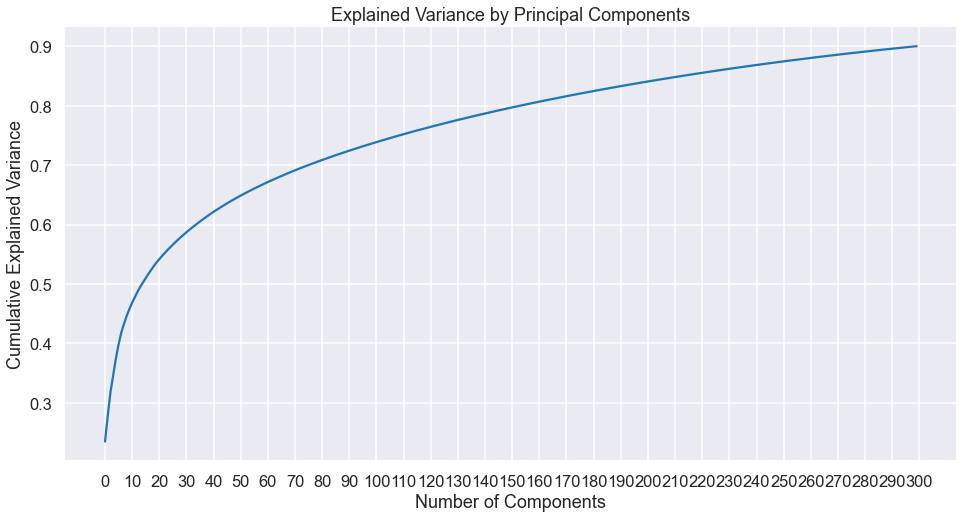

0.9004744226379353


In [16]:
pca_all_thresh, df_pc_all_thresh, df_scaled_all_thresh = transform_pca(
    df_common_alldose, dose_num=None, no_of_pcs=number_of_pcs
)

print(np.sum(pca_all_thresh.explained_variance_ratio_))

In [17]:
def plot_pca_var(pca, pc_num):
    
    #plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (14, 8))
    df_var = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC' + str(x) for x in range(1,pc_num+1)]})
    df_var['var'] = df_var['var'] * 100
    #sns.barplot(x='PC',y="var", data=df_var, color="c")
    plt.bar(df_var['PC'], df_var['var'], color ='c')
    plt.xlim(0, pc_num+1)
    plt.ylabel('Explained Variance %')
    plt.xlabel('Principal Components')
    plt.xticks(np.arange(0, pc_num, step=20))
    plt.title("Amount of variance explained by each Principal component for Cell painting level-4 profiles")
    ##plt.savefig('cluster_images/var_exp_PCA.png')
    plt.show()
    
    return df_var

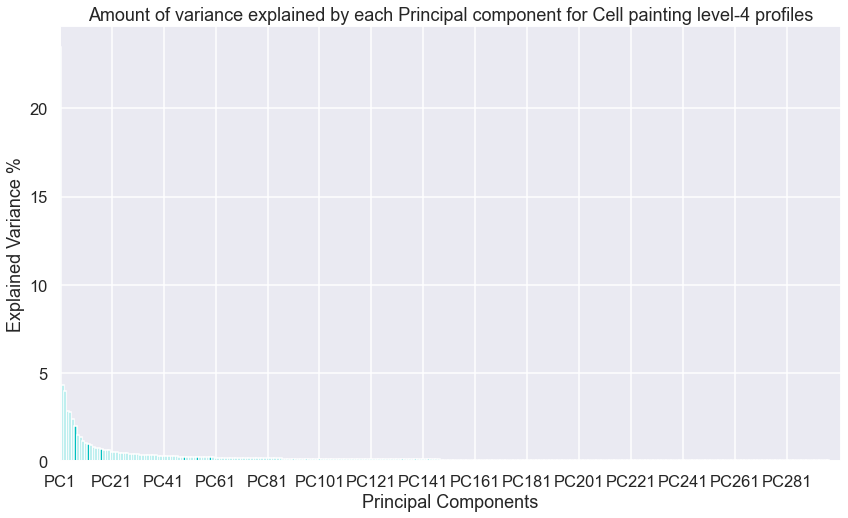

In [18]:
df_var_full = plot_pca_var(pca_all_thresh, number_of_pcs)
save_to_csv(df_var_full, output_path, 'cp_pca_explained_variance.csv')

In [19]:
doseall_thresh_silh_score, doseall_thresh_davie_score = calculate_score(df_pc_all_thresh.drop(['dose'], axis = 1))

df_silhall_thresh = create_df(doseall_thresh_silh_score, 'Average_silhouette_score', "common_compounds")
df_dball_thresh = create_df(doseall_thresh_davie_score, 'davies_bouldin_score', "common_compounds")

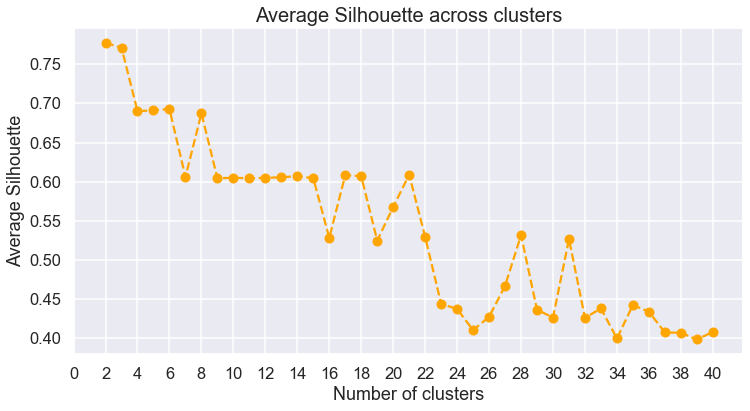

In [20]:
plot_score(doseall_thresh_silh_score, 'Average Silhouette')

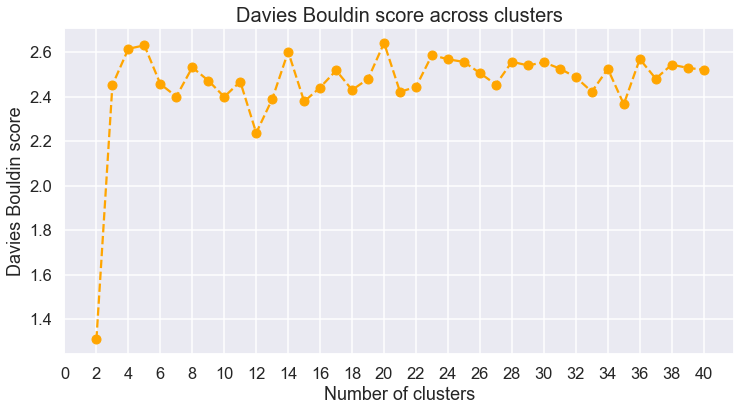

In [21]:
plot_score(doseall_thresh_davie_score, 'Davies Bouldin score')

In [22]:
# Output to file
output_file = pathlib.Path("results/cell_painting/cp_silhouette_scores_compounds_common_compounds.csv")
df_silhall_thresh.to_csv(output_file, index=False)

output_file = pathlib.Path("results/cell_painting/cp_davies_compounds_common_compounds.csv")
df_dball_thresh.to_csv(output_file, index=False)

## Perform the same analysis within each dose separately

Now analyzing dose 1


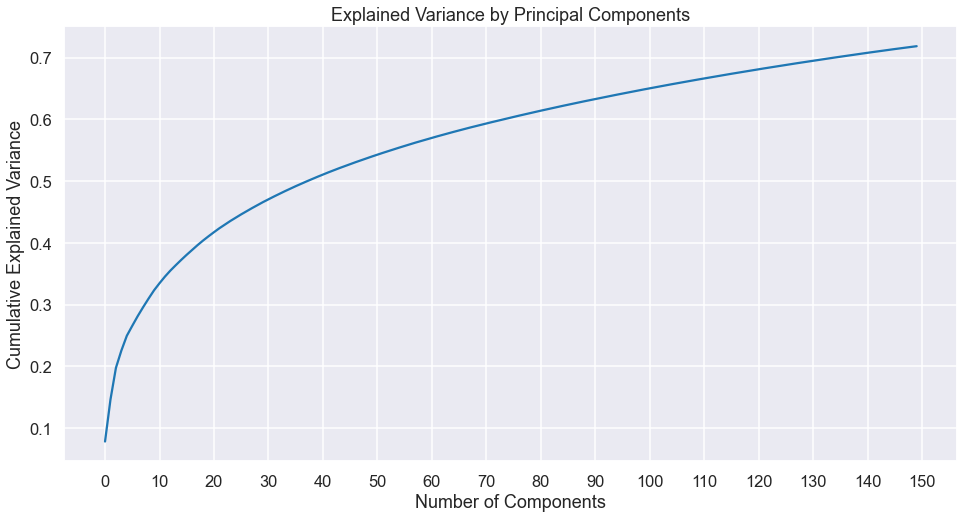

0.7184800427867266
Now analyzing dose 2


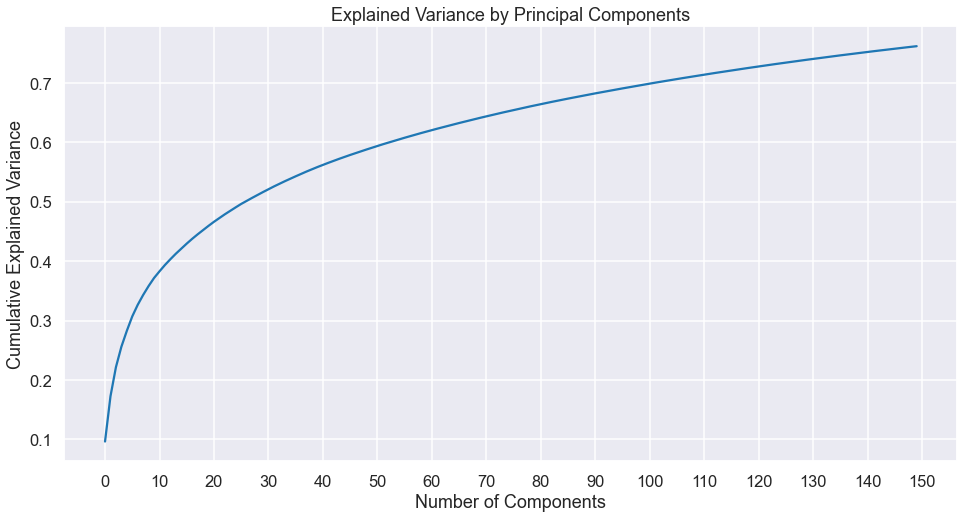

0.7616278563805677
Now analyzing dose 3


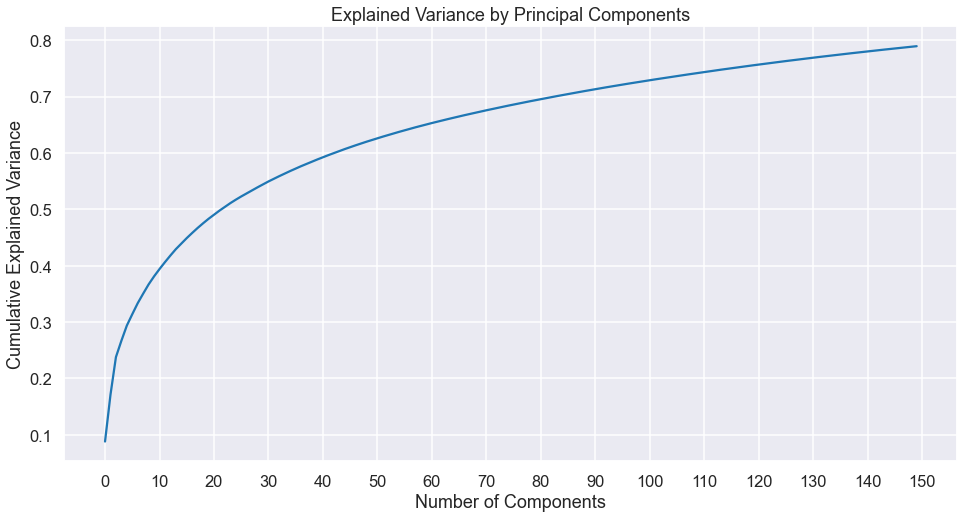

0.7896737692124792
Now analyzing dose 4


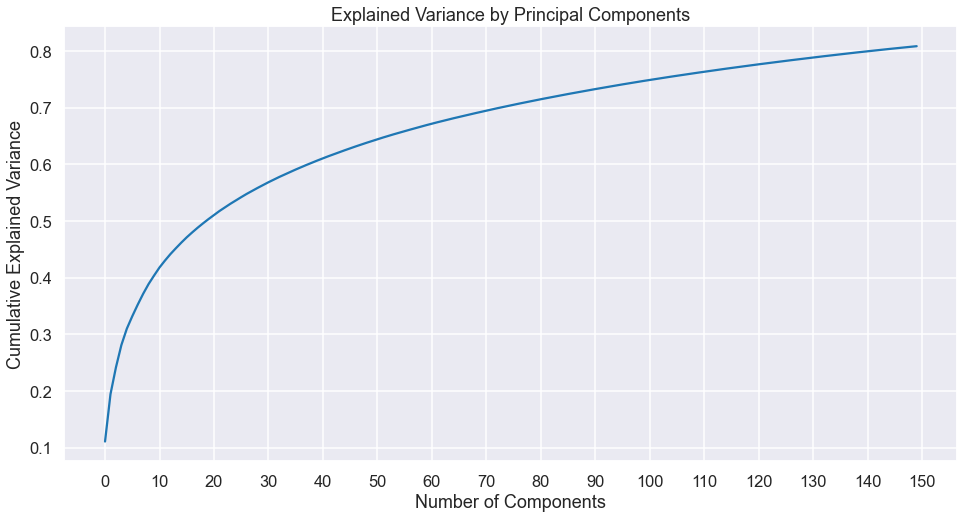

0.8084319302087639
Now analyzing dose 5


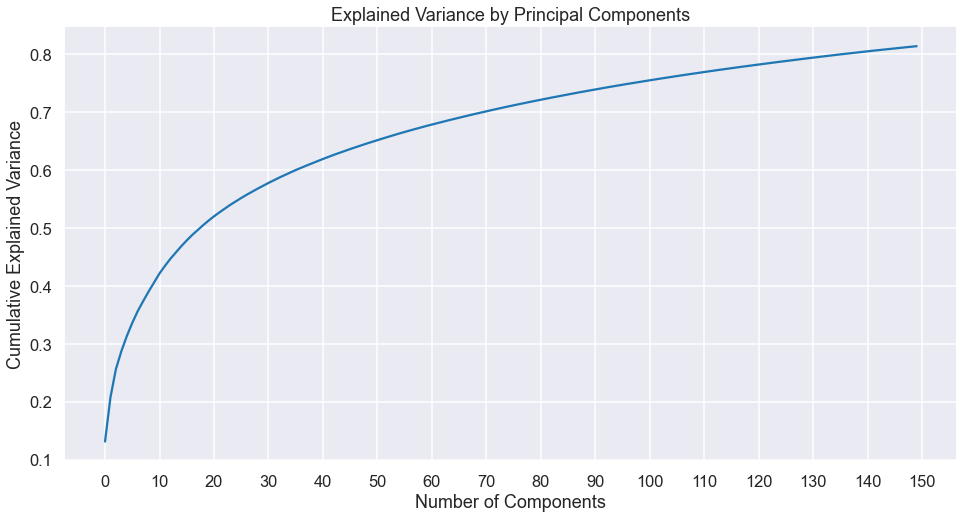

0.8137158901658349
Now analyzing dose 6


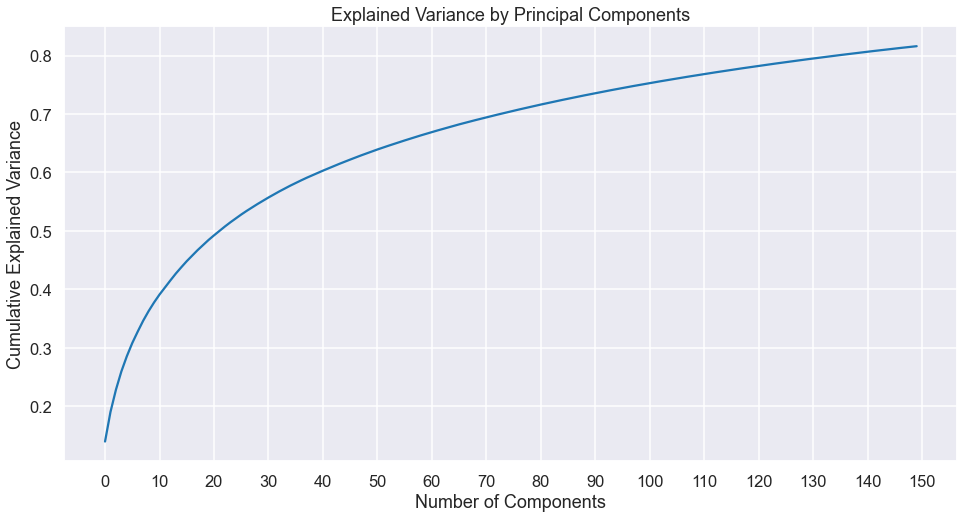

0.8159657984867552


In [23]:
silh_list = []
db_list = []
#bic_list = []

for dose in [1, 2, 3, 4, 5, 6]:
    print(f"Now analyzing dose {dose}")
    df_dose = extract_dose_df(df_level4, dose_num=dose)
    pca_dose, df_pc_dose, df_scaled_dose = transform_pca(df_dose, dose_num=dose)
    
    print(np.sum(pca_dose.explained_variance_ratio_)) 
        
    # Do not calculate BIC
    #bics_dose, _ = calc_bic(df_pc_dose.drop(['dose'], axis = 1))
    #dose_bic_score = {idx+2:score for idx, score in enumerate(bics_dose)}
    
    # Calculate Silhouette and Davies Boulding index
    dose_silh_score, dose_davie_score = calculate_score(df_pc_dose.drop(['dose'], axis = 1))
    
    # Save output
    df_silh = create_df(dose_silh_score, 'Average_silhouette_score', dose)
    silh_list.append(df_silh)
    df_db = create_df(dose_davie_score, 'davies_bouldin_score', dose)
    db_list.append(df_db)
    #df_bic = create_df(dose_bic_score, 'BIC_score', 1)
    #bic_list.append(dfbic)
    
df_silh = pd.concat(silh_list, ignore_index=True)
df_db = pd.concat(db_list, ignore_index=True)
#df_bic = pd.concat(bic_list, ignore_index=True)

In [24]:
save_to_csv(df_silh, output_path, 'cp_silhouette_scores.csv')
save_to_csv(df_db, output_path, 'cp_db_scores.csv')
#save_to_csv(df_bic, output_path, 'cp_bic_scores.csv')